In [1]:
import pandas as pd
import feather
import altair as alt

## Utility functions

In [2]:
def is_active(start_date, end_date, funding_entity, current_date, current_entity):
    if (
        start_date <= current_date
        and (end_date >= current_date or pd.isnull(end_date))
        and funding_entity == current_entity
    ):
        return 1

    return 0


def count_active(date, funder, ads_df):
    count = sum(
        [
            is_active(start, end, entity, date, funder)
            for start, end, entity in zip(
                ads_df["start_normalized"],
                ads_df["stop_normalized"],
                ads_df["funding_entity"],
            )
        ]
    )

    return count


def is_active_registered(start_date, end_date, classification, current_date):
    if (
        start_date <= current_date
        and (end_date >= current_date or pd.isnull(end_date))
        and classification == "Registered non-party campaigner"
    ):
        return 1

    return 0


def count_active_registered(date, ads_df):
    count = sum(
        [
            is_active_registered(start, end, classification, date)
            for start, end, classification in zip(
                ads_df["start_normalized"],
                ads_df["stop_normalized"],
                ads_df["classification"],
            )
        ]
    )

    return count


def is_active_unclassified(
    start_date, end_date, funding_entity, classification, current_date
):
    if (
        start_date <= current_date
        and (end_date >= current_date or pd.isnull(end_date))
        and classification == "UNCLASSIFIED"
    ):
        return 1

    return 0


def count_active_unclassified(date, ads_df):
    count = sum(
        [
            is_active_unclassified(start, end, entity, classification, date)
            for start, end, entity, classification in zip(
                ads_df["start_normalized"],
                ads_df["stop_normalized"],
                ads_df["disclaimer"],
                ads_df["classification"],
            )
        ]
    )

    return count


def is_active_no_funder(start_date, end_date, funding_entity, current_date):
    if (
        start_date <= current_date
        and (end_date >= current_date or pd.isnull(end_date))
        and funding_entity == "missing: funding_entity"
    ):
        return 1

    return 0


def count_active_no_funder(date, ads_df):
    count = sum(
        [
            is_active_no_funder(start, end, entity, date)
            for start, end, entity in zip(
                ads_df["start_normalized"],
                ads_df["stop_normalized"],
                ads_df["funding_entity"],
            )
        ]
    )

    return count

## Load pre-classified funding entities

In [3]:
df_advertisers_classified = (
    pd.read_csv(
        "../data/raw/facebook-ad-library/fb-advertisers-classified-2019-12-01.csv"
    )
    .assign(disclaimer=lambda df: df["disclaimer"].str.lower().str.strip())
    .drop_duplicates("disclaimer")
)

print(len(df_advertisers_classified))
print(df_advertisers_classified.dtypes)
df_advertisers_classified.head()

1696
disclaimer        object
classification    object
dtype: object


,disclaimer,classification
0,10:10 climate action,UNCLASSIFIED
1,100 million/kscf-us,UNCLASSIFIED
2,38 degrees,Registered non-party campaigner
4,5pillars,UNCLASSIFIED
5,a little bit of stone,UNCLASSIFIED


## Load ads and merge with classifications

In [4]:
df_ads = (
    feather.read_dataframe("../data/processed/fb-ads-2019-12-03.feather")
    .assign(funding_entity=lambda df: df["funding_entity"].str.lower().str.strip())
    .assign(page_name=lambda df: df["page_name"].str.lower().str.strip())
    .assign(start_normalized=lambda df: df["ad_delivery_start_time"].dt.normalize())
    .assign(stop_normalized=lambda df: df["ad_delivery_stop_time"].dt.normalize())
    .assign(creation_normalized=lambda df: df["ad_creation_time"].dt.normalize())
    .merge(
        df_advertisers_classified,
        "left",
        left_on="funding_entity",
        right_on="disclaimer",
    )
)

print(len(df_ads))
print(df_ads.dtypes)
df_ads.head()

172352
ad_creation_time                datetime64[ns, UTC]
ad_creative_body                             object
ad_creative_link_caption                     object
ad_creative_link_description                 object
ad_creative_link_title                       object
ad_delivery_start_time          datetime64[ns, UTC]
ad_delivery_stop_time           datetime64[ns, UTC]
ad_snapshot_url                              object
currency                                     object
demographic_distribution                     object
funding_entity                               object
impressions                                  object
page_id                                       int64
page_name                                    object
publisher_platforms                          object
region_distribution                          object
spend                                        object
impressions_lower                             int64
impressions_upper                           float64
spend

,ad_creation_time,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_creative_link_title,ad_delivery_start_time,ad_delivery_stop_time,ad_snapshot_url,currency,demographic_distribution,...,impressions_lower,impressions_upper,spend_lower,spend_upper,ad_id,start_normalized,stop_normalized,creation_normalized,disclaimer,classification
0,2019-12-03 10:25:54+00:00,You have the power to stop Boris Johnson on 12...,remainunited.org,Find out how to vote in your constituency.,"Smart, data-driven advice",2019-12-03 10:25:54+00:00,2019-12-06 23:59:00+00:00,https://www.facebook.com/ads/archive/render_ad...,GBP,"[{""percentage"": ""1"", ""age"": ""45-54"", ""gender"":...",...,0,999.0,0,99.0,955935358113516,2019-12-03 00:00:00+00:00,2019-12-06 00:00:00+00:00,2019-12-03 00:00:00+00:00,centrum campaign ltd,Registered non-party campaigner
1,2019-12-03 10:25:39+00:00,You have the power to stop Boris Johnson on 12...,remainunited.org,Find out how to vote in your constituency.,"Smart, data-driven advice",2019-12-03 10:25:39+00:00,2019-12-06 23:59:00+00:00,https://www.facebook.com/ads/archive/render_ad...,GBP,"[{""percentage"": ""1"", ""age"": ""45-54"", ""gender"":...",...,0,999.0,0,99.0,445143209713828,2019-12-03 00:00:00+00:00,2019-12-06 00:00:00+00:00,2019-12-03 00:00:00+00:00,centrum campaign ltd,Registered non-party campaigner
2,2019-12-03 10:22:47+00:00,You have the power to stop Boris Johnson on 12...,remainunited.org,Find out how to vote in your constituency.,"Smart, data-driven advice",2019-12-03 10:22:47+00:00,2019-12-06 23:59:00+00:00,https://www.facebook.com/ads/archive/render_ad...,GBP,"[{""percentage"": ""0.5"", ""age"": ""18-24"", ""gender...",...,0,999.0,0,99.0,579847832831823,2019-12-03 00:00:00+00:00,2019-12-06 00:00:00+00:00,2019-12-03 00:00:00+00:00,centrum campaign ltd,Registered non-party campaigner
3,2019-12-03 10:21:22+00:00,You have the power to stop Boris Johnson on 12...,remainunited.org,Find out how to vote in your constituency.,"Smart, data-driven advice",2019-12-03 10:21:22+00:00,2019-12-06 23:59:00+00:00,https://www.facebook.com/ads/archive/render_ad...,GBP,"[{""percentage"": ""1"", ""age"": ""25-34"", ""gender"":...",...,0,999.0,0,99.0,791774841263210,2019-12-03 00:00:00+00:00,2019-12-06 00:00:00+00:00,2019-12-03 00:00:00+00:00,centrum campaign ltd,Registered non-party campaigner
4,2019-12-03 10:18:02+00:00,You have the power to stop Boris Johnson on 12...,remainunited.org,Find out how to vote in your constituency.,"Smart, data-driven advice",2019-12-03 10:18:02+00:00,2019-12-06 23:59:00+00:00,https://www.facebook.com/ads/archive/render_ad...,GBP,"[{""percentage"": ""0.333333"", ""age"": ""25-34"", ""g...",...,0,999.0,0,99.0,772692536543292,2019-12-03 00:00:00+00:00,2019-12-06 00:00:00+00:00,2019-12-03 00:00:00+00:00,centrum campaign ltd,Registered non-party campaigner


## Count active ads per day

In [5]:
df_active_daily = (
    pd.DataFrame(
        {"date": pd.date_range(start="2019-10-01", end="2019-12-01").tz_localize("UTC")}
    )
    .assign(
        con=lambda df: [
            count_active(date, "the conservative party", df_ads) for date in df["date"]
        ]
    )
    .assign(
        scot_con=lambda df: [
            count_active(date, "scottish conservatives", df_ads) for date in df["date"]
        ]
    )
    .assign(
        lab=lambda df: [
            count_active(date, "the labour party", df_ads) for date in df["date"]
        ]
    )
    .assign(
        corbyn=lambda df: [
            count_active(date, "the labour party on behalf of jeremy corbyn", df_ads)
            for date in df["date"]
        ]
    )
    .assign(
        scot_lab=lambda df: [
            count_active(date, "scottish labour party", df_ads) for date in df["date"]
        ]
    )
    .assign(
        wal_lab=lambda df: [
            count_active(date, "welsh labour", df_ads) for date in df["date"]
        ]
    )
    .assign(
        lib=lambda df: [
            count_active(date, "the liberal democrats", df_ads) for date in df["date"]
        ]
    )
    .assign(
        brx=lambda df: [
            count_active(date, "the brexit party", df_ads) for date in df["date"]
        ]
    )
    .assign(
        wal_brx=lambda df: [
            count_active(date, "the brexit party in wales", df_ads)
            for date in df["date"]
        ]
    )
    .assign(
        gre=lambda df: [
            count_active(date, "green party of england and wales", df_ads)
            for date in df["date"]
        ]
    )
#     .assign(
#         dup=lambda df: [
#             count_active(date, "democratic unionist party", df_ads)
#             for date in df["date"]
#         ]
#     )
#     .assign(
#         pla=lambda df: [
#             count_active(date, "plaid cymru", df_ads) for date in df["date"]
#         ]
#     )
    .assign(
        registered=lambda df: [
            count_active_registered(date, df_ads) for date in df["date"]
        ]
    )
    .assign(
        unclassified=lambda df: [
            count_active_unclassified(date, df_ads) for date in df["date"]
        ]
    )
    .assign(
        no_funder=lambda df: [
            count_active_no_funder(date, df_ads) for date in df["date"]
        ]
    )
)

print(len(df_active_daily))
print(df_active_daily.dtypes)
df_active_daily.head()

62
date            datetime64[ns, UTC]
con                           int64
scot_con                      int64
lab                           int64
corbyn                        int64
scot_lab                      int64
wal_lab                       int64
lib                           int64
brx                           int64
wal_brx                       int64
gre                           int64
registered                    int64
unclassified                  int64
no_funder                     int64
dtype: object


,date,con,scot_con,lab,corbyn,scot_lab,wal_lab,lib,brx,wal_brx,gre,registered,unclassified,no_funder
0,2019-10-01 00:00:00+00:00,9157,0,639,0,18,1,1037,111,0,0,7596,3474,14522
1,2019-10-02 00:00:00+00:00,9157,0,643,0,18,0,1043,111,0,0,7596,3489,14563
2,2019-10-03 00:00:00+00:00,9160,0,648,0,18,1,1043,112,0,0,7600,3491,14658
3,2019-10-04 00:00:00+00:00,9160,0,648,0,18,0,1043,112,0,0,7642,3553,14866
4,2019-10-05 00:00:00+00:00,9159,0,636,0,17,0,1043,112,0,0,7640,3543,14859


## Transform for plotting

In [6]:
series_order = {
    "no_funder": 0,
    "unclassified": 1,
    "registered": 2,
    "gre": 3,
    "brx": 4,
    "lab": 5,
    "lib": 6,
    "con": 7,
}

series_order

{'no_funder': 0,
 'unclassified': 1,
 'registered': 2,
 'gre': 3,
 'brx': 4,
 'lab': 5,
 'lib': 6,
 'con': 7}

In [7]:
df_active_plot = (
    df_active_daily.copy()
    .assign(con=lambda df: df["con"] + df["scot_con"])
    .assign(lab=lambda df: df["lab"] + df["corbyn"] + df["scot_lab"] + df["wal_lab"])
    .assign(brx=lambda df: df["brx"] + df["wal_brx"])
    .drop(["scot_con", "corbyn", "scot_lab", "wal_lab", "wal_brx"], axis=1)
    .melt(
        id_vars=["date"],
        value_vars=[
            "con",
            "lab",
            "lib",
            "brx",
            "gre",
            "registered",
            "unclassified",
            "no_funder",
        ],
        var_name="funder",
        value_name="active_ads",
    )
    .assign(order=lambda df: df["funder"].apply(lambda x: series_order.get(x)))
)

df_active_plot.head()

,date,funder,active_ads,order
0,2019-10-01 00:00:00+00:00,con,9157,7
1,2019-10-02 00:00:00+00:00,con,9157,7
2,2019-10-03 00:00:00+00:00,con,9160,7
3,2019-10-04 00:00:00+00:00,con,9160,7
4,2019-10-05 00:00:00+00:00,con,9159,7


## Plot area

In [8]:
parties_palette = alt.Scale(
    domain=["con", "lab", "lib", "brx", "gre", "no_funder", "unclassified", "registered"],
    range=["#149adb", "#cf4d3c", "#f09000", "#80cfd6", "#8deb9d", "#33302e", "#807973", "#ccc1b7"],
)

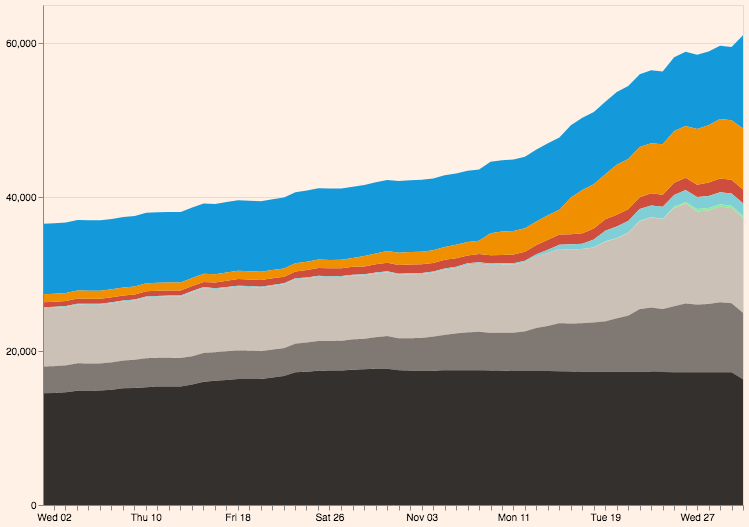

In [9]:
alt.Chart(df_active_plot, background="#fff1e5").mark_area().encode(
    x=alt.X("date:T", axis=alt.Axis(tickCount=len(df_active_daily), title=None, grid=False)),
    y=alt.Y("active_ads:Q", axis=alt.Axis(tickCount=4, title=None)),
    color=alt.Color("funder:N", scale=parties_palette, legend=None),
    order="order",
    tooltip=["funder", "active_ads", "date"],
).properties(width=700, height=500)

## Write to `.feather`

In [10]:
feather.write_dataframe(df_active_daily, "../data/processed/fb-active-ads-daily-2019-12-03.feather")